In [3]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import json
from Utils.evaluation import EvaluationMetrics, ActualStats
from Utils.helper import *
from Utils.sample_squads import *

## Initialize

In [4]:
model_inn1 = tf.keras.models.load_model('Models\Inn1-HeavyDense-ep20to50\cp-0029.h5')
model_inn2 = tf.keras.models.load_model('Models\Inn2-HeavyDenseRequired-ep30to50\cp-0016.h5')

In [5]:
evaluator = EvaluationMetrics(model_inn1, model_inn2,
                              # )
                              "Evaluation/tournament3_1.pkl")

In [6]:
# set_bs = set(BS_Cols)
# for i in evaluator.teams:
#     (batting, bowling), venue = i
#     for name in batting[1:]:
#         if "Striker_"+name not in set_bs:
#             print("Striker_"+name)
#         if "Non_Striker_"+name not in set_bs:
#             print("Non_Striker_"+name)
#         if "Bowler_"+name not in set_bs:
#             print("Bowler_"+name)
#     for name in bowling[1:]:
#         if "Striker_"+name not in set_bs:
#             print("Striker_"+name)
#         if "Non_Striker_"+name not in set_bs:
#             print("Non_Striker_"+name)
#         if "Bowler_"+name not in set_bs:
#             print("Bowler_"+name)
#     if "Venue_"+venue not in set_bs:
#         print("Venue_"+venue)
#     if "Batting_Team_"+batting[0] not in set_bs:
#         print("Batting_Team_"+batting[0])
#     if "Batting_Team_"+bowling[0] not in set_bs:
#         print("Batting_Team_"+bowling[0])
#     if "Toss_"+batting[0] not in set_bs:
#         print("Toss_"+batting[0])
#     if "Toss_"+bowling[0] not in set_bs:
#         print("Toss_"+bowling[0])
#     if "Bowling_Team_"+batting[0] not in set_bs:
#         print("Bowling_Team_"+batting[0])
#     if "Bowling_Team_"+bowling[0] not in set_bs:
#         print("Bowling_Team_"+bowling[0])

In [7]:
# num_tournaments = 5
# verbose = 0
# for t in range(num_tournaments):
#     print(f"Tournament {t+1}/{num_tournaments}:")
#     evaluator.reinitialize_tournament()
#     for _ in tqdm(range(56), ncols=80, disable=True if verbose!=0 else False):
#         if verbose != 0:
#             print(f"\n\nMatch number: {evaluator.match_count+1}")   
#         evaluator.simulate_match(verbose)   
#     evaluator.display_table()
#     evaluator.save_object("Evaluation/tournament3_1.pkl")

In [9]:
actualstat = ActualStats("Evaluation/actual.pkl")
# actualstat = ActualStats()
# actualstat.run_df(1, True)
# actualstat.run_df(2, True)
# actualstat.save_object("Evaluation/actual.pkl")   

In [10]:
len(actualstat.chasing_stat), len(actualstat.total_stat)

(795, 796)

## First Innings Target Evaluation

In [11]:
from scipy import stats
# stats.ttest_ind(evaluator.total_stat[::2], actualstat.total_stat, equal_var=False)
stats.ks_2samp(evaluator.total_stat, actualstat.total_stat)


KstestResult(statistic=0.036486001435750176, pvalue=0.933793526744867)

In [12]:
len(evaluator.total_stat), len(actualstat.total_stat)

(280, 796)

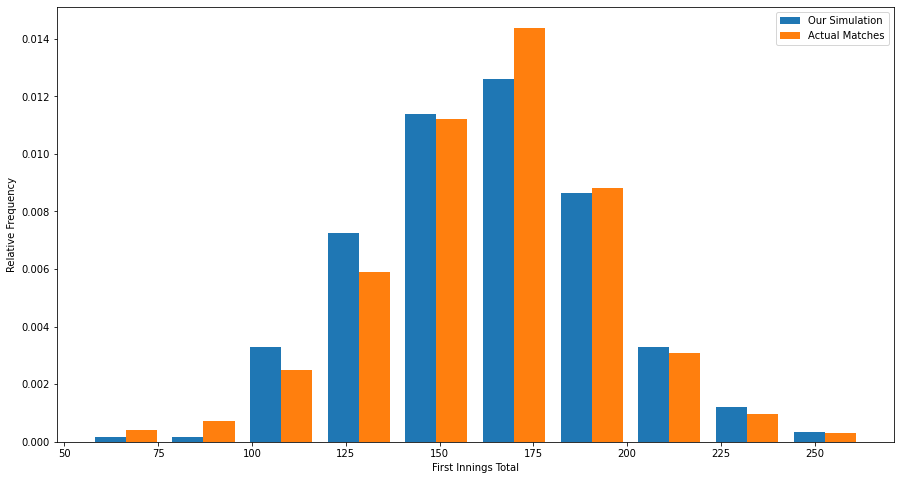

In [15]:
import matplotlib.pyplot as plt
plt.hist([evaluator.total_stat, actualstat.total_stat], density=True, bins=10, label=["Our Simulation", "Actual Matches"])
plt.legend()
plt.xlabel("First Innings Total")
plt.ylabel("Relative Frequency")
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [16]:
import statistics
import math
mean_sim = statistics.mean(evaluator.total_stat)
variance_sim = statistics.variance(evaluator.total_stat)
mean_actual = statistics.mean(actualstat.total_stat)
variance_actual = statistics.variance(actualstat.total_stat)
z = abs(mean_actual - mean_sim)/(math.sqrt(variance_actual+variance_sim))
print(z)

0.006341691325247162


In [17]:
mean_actual, mean_sim,variance_actual, variance_sim

(162.44095477386935, 162.71428571428572, 917.474496697323, 940.1904761904761)

## Second Innings Evaluation

In [31]:
actual_chasing_stat = actualstat.chasing_stat
# evaluator_chasing_stat = evaluator.chasing_stat
# actual_chasing_stat
evaluator_chasing_stat = []
for inn1, inn2 in evaluator.innings_obj_list:
    row_dic = {}
    row_dic["Final Score"] = [inn2.Runs, inn2.Wickets]
    row_dic["First_Innings_Score"] = inn1.Runs
    row_dic["Overs"] = [inn2.Overs - 1, inn2.Balls - 1]
    final_score = inn2.Runs
    first_innings_score = inn1.Runs
    if final_score > first_innings_score:
            outcome = 1
    elif final_score == first_innings_score:
        outcome = 0
    elif final_score < first_innings_score:
        outcome = -1
    else:
        assert False, "Wrong if conditions"
    row_dic["Outcome"] = outcome
    evaluator_chasing_stat.append(row_dic)

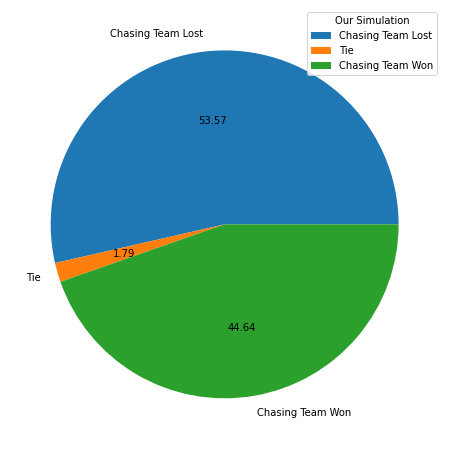

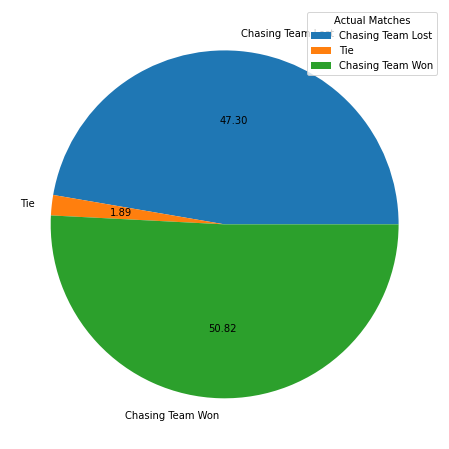

In [36]:
actual_chasing_outcome = [i["Outcome"] for i in actual_chasing_stat]
evaluator_chasing_outcome = [i["Outcome"] for i in evaluator_chasing_stat]
pie_lis = []
labels = ["Chasing Team Lost", "Tie", "Chasing Team Won"]
for outcome_lis in [evaluator_chasing_outcome, actual_chasing_outcome]:
    res_dist = {}
    for res in (outcome_lis):
        if res in res_dist:
            res_dist[res] += 1
        else:
            res_dist[res] = 1
    pie_lis.append([res_dist[i] for i in sorted(res_dist)])

fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.pie(pie_lis[0], labels=labels, autopct="%.2f")
plt.legend(title = "Our Simulation")
plt.show()
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.pie(pie_lis[1], labels=labels, autopct="%.2f")
plt.legend(title = "Actual Matches")
plt.show()

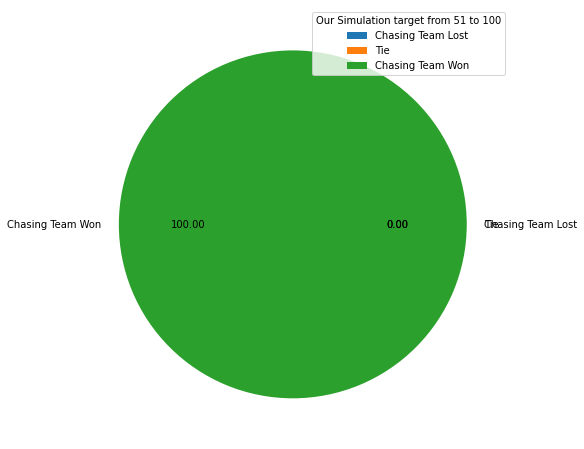

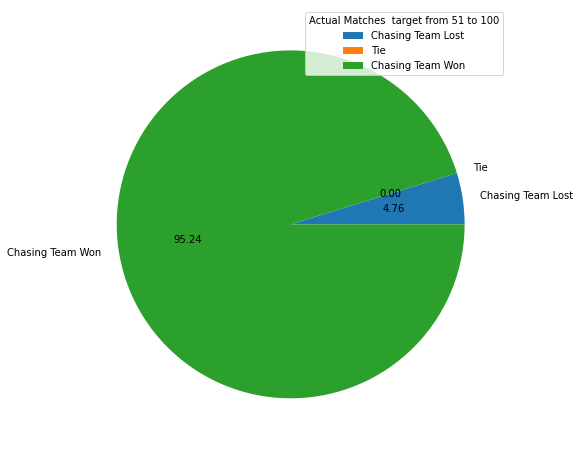

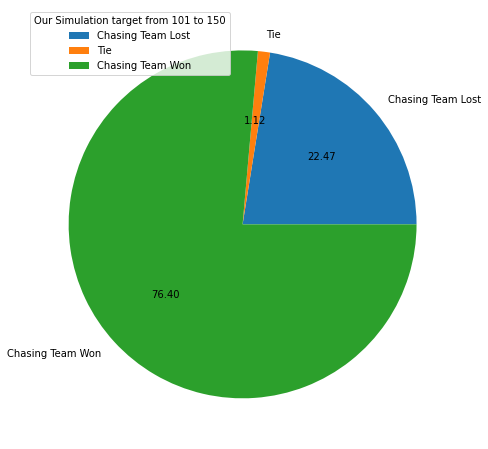

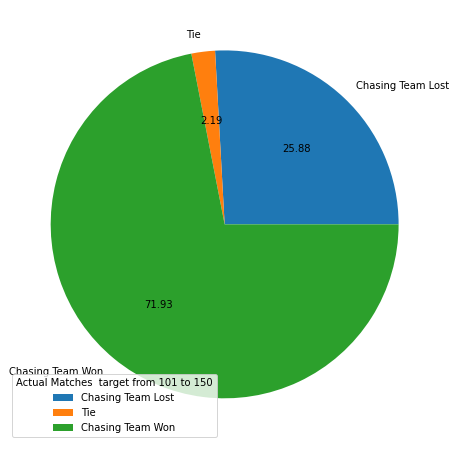

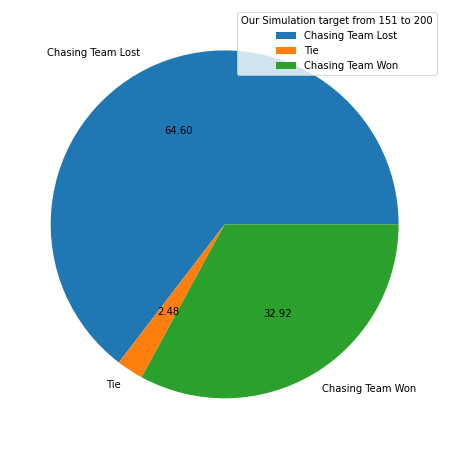

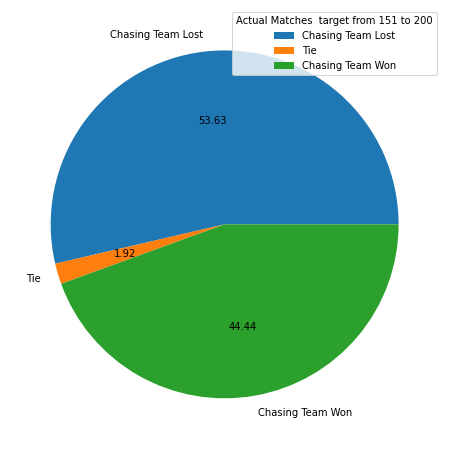

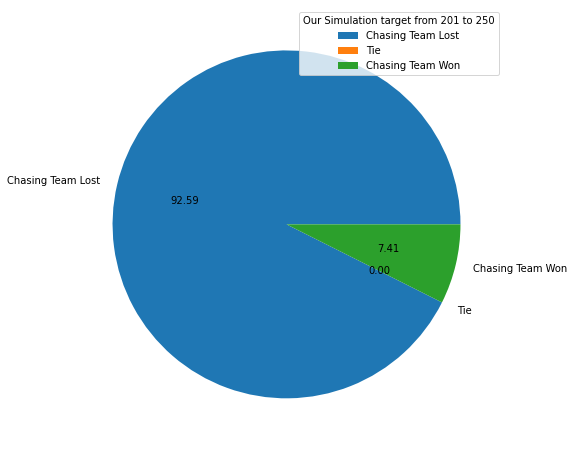

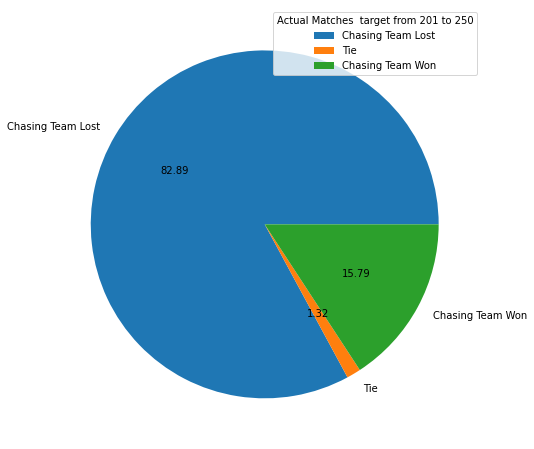

In [48]:
step = 50
for inn1_start, inn1_end in [[i+1, i+step] for i in range(50, 250, step)]:
    actual_chasing_outcome = [i["Outcome"] for i in actual_chasing_stat 
                            if (inn1_start <= i["First_Innings_Score"] <= inn1_end)]
    evaluator_chasing_outcome = [i["Outcome"] for i in evaluator_chasing_stat
                                if (inn1_start <= i["First_Innings_Score"] <= inn1_end)]
    pie_lis = []
    labels = ["Chasing Team Lost", "Tie", "Chasing Team Won"]
    for outcome_lis in [evaluator_chasing_outcome, actual_chasing_outcome]:
        res_dist = { -1: 0, 0: 0, 1: 0}
        for res in (outcome_lis):
            if res in res_dist:
                res_dist[res] += 1
            else:
                res_dist[res] = 1
        pie_lis.append([res_dist[i] for i in sorted(res_dist)])

    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.pie(pie_lis[0], labels=labels, autopct="%.2f")
    plt.legend(title = f"Our Simulation target from {inn1_start} to {inn1_end}")
    plt.show()
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.pie(pie_lis[1], labels=labels, autopct="%.2f")
    plt.legend(title = f"Actual Matches  target from {inn1_start} to {inn1_end}")
    plt.show()

## Progression Evaluation

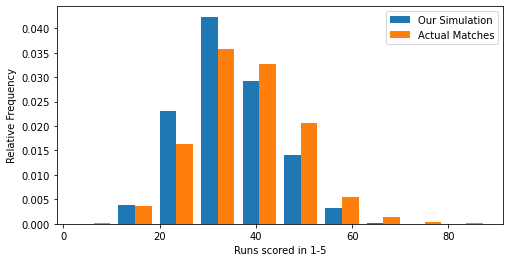

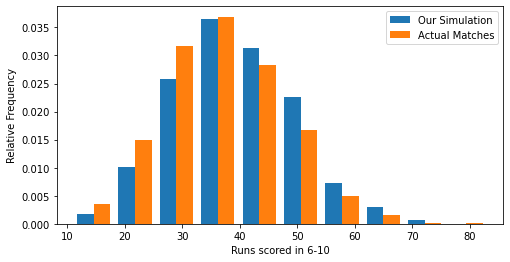

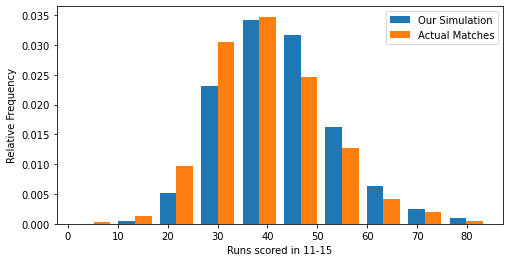

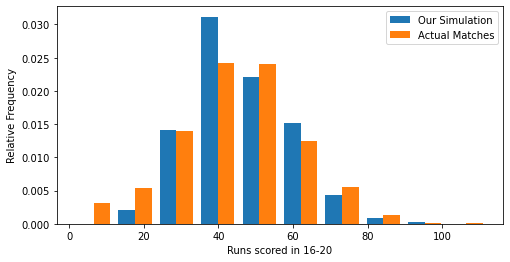

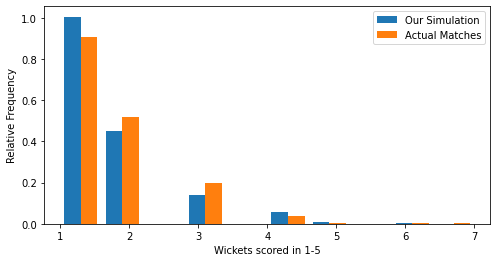

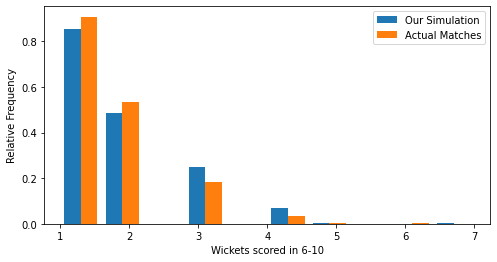

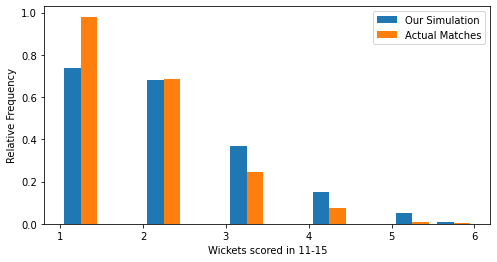

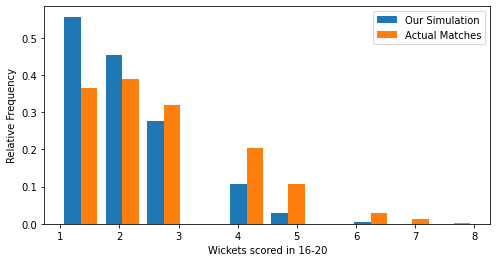

In [18]:
import matplotlib.pyplot as plt
for key in ["runs", "wickets"]:
    for i in range(4):
        plt.hist([[k for k in evaluator.progression_stat[key][i] if k!=0], [k for k in actualstat.progression_stat[key][i] if k!=0]],
                 density=True, bins=10, label=["Our Simulation", "Actual Matches"])
        plt.legend()
        plt.xlabel(f"{key.title()} scored in {i*5+1}-{i*5+5}")
        plt.ylabel("Relative Frequency")
        fig = plt.gcf()
        fig.set_size_inches(8, 4)
        plt.show()

## Batsmen Statistics

In [19]:
batsmen_result_dic = {}
bat_stat = evaluator.batsmen_stat
for batsman in bat_stat:
    tot_runs = 0
    tot_balls = 0
    num_4 = 0
    num_6 = 0
    num_inn = 0
    num_out = 0
    hs = [0, ""]
    dismissal_type = []
    dismissed_by = []
    for i in bat_stat[batsman]:
        num_inn += 1
        tot_runs += i["Runs"]
        if i["Runs"] > hs[0] or (i["Runs"] == hs[0] and hs[1] == ""):
            hs[0] = i["Runs"]
            if i["Dismissal Type"] != "Not Out":
                hs[1] = "*"
        tot_balls += i["Balls Faced"]
        num_4 += i["Fours"]
        num_6 += i["Sixes"]
        if i["Dismissal Type"] != "Not Out":
            num_out += 1
        dismissal_type.append(i["Dismissal Type"])
        dismissed_by.append(i["Dismissed By"])
    batsmen_result_dic[batsman] = {
        "Innings": num_inn,
        "Runs": tot_runs,
        "Balls": tot_balls,
        "Fours": num_4,
        "Sixes": num_6,
        "High Score": "".join([str(i) for i in hs]),
        "Average": tot_runs/num_out if num_out!=0 else tot_runs,
        "Strike Rate": tot_runs/tot_balls*100 if tot_balls!=0 else 0,
        "Boundry Percent": (6*num_6+4*num_4)/tot_runs*100 if tot_runs!=0 else 0,
        }
batsmen_stat_df = pd.DataFrame.from_dict(batsmen_result_dic, orient='index')
save_df = batsmen_stat_df.sort_values(by=["Runs", "Balls"], ascending=False)
save_df.to_csv("Evaluation/Evaluate_Batsmen.csv")
save_df.head(20)

,Innings,Runs,Balls,Fours,Sixes,High Score,Average,Strike Rate,Boundry Percent
PA Patel,70,2642,1953,283,95,118*,44.033333,135.279058,64.420893
RG Sharma,70,2437,1855,265,75,109,39.950820,131.374663,61.961428
CH Gayle,70,2194,1638,260,75,123*,34.281250,133.943834,67.912489
CA Lynn,70,2165,1735,238,59,101*,32.803030,124.783862,60.323326
S Dhawan,70,2154,1669,223,71,97,33.656250,129.059317,61.188487
Q de Kock,70,2136,1638,234,76,111*,32.363636,130.402930,65.168539
DA Warner,70,2052,1587,212,69,111*,33.096774,129.300567,61.500975
SR Watson,70,2030,1595,221,60,107,32.741935,127.272727,61.280788
KL Rahul,70,2020,1637,201,69,129*,31.076923,123.396457,60.297030
AM Rahane,70,2007,1578,217,59,103*,30.876923,127.186312,60.886896


## Bowler Statistics

In [20]:
bowler_result_dic = {}
bowler_stat = evaluator.bowler_stat
for bowler in bowler_stat:
    tot_runs = 0
    tot_balls = 0
    tot_wickets = 0
    for i in bowler_stat[bowler]:
        tot_runs += i["Runs Conceded"]
        tot_balls += i["Balls"]
        tot_wickets += i["Wickets Taken"]
    bowler_result_dic[bowler] = {
        "Runs Conceded": tot_runs,
        "Overs": f"{tot_balls//6}.{tot_balls%6}",
        "Wickets": tot_wickets,
        "Economy": tot_runs/tot_balls*6 if tot_balls != 0 else 0,
        }
bowler_stat_df = pd.DataFrame.from_dict(bowler_result_dic, orient='index')
save_df = bowler_stat_df.sort_values(by=["Wickets", "Economy"], ascending=[False, True])
save_df.to_csv("Evaluation/Evaluate_Bowler.csv")
save_df.head(20)

,Runs Conceded,Overs,Wickets,Economy
SL Malinga,1862,252.3,87,7.374257
S Kaul,2264,274.5,83,8.237720
SN Thakur,1980,271.5,80,7.283875
JJ Bumrah,2008,261.4,80,7.673885
C de Grandhomme,2345,272.0,80,8.621324
RD Chahar,2176,276.4,79,7.865060
Imran Tahir,2262,278.2,78,8.126946
KH Pandya,2327,278.3,78,8.355476
SP Narine,1960,256.2,77,7.646294
A Mishra,2255,276.4,77,8.150602


## Players Matchwise Evaluation 

In [21]:
actual_batsmen_df = pd.read_csv("Evaluation/Actual_Batsmen.csv")
evaluate_batsmen_df = pd.read_csv("Evaluation/Evaluate_Batsmen.csv")
actual_bowler_df = pd.read_csv("Evaluation/Actual_Bowler.csv")
evaluate_bowler_df = pd.read_csv("Evaluation/Evaluate_Bowler.csv")

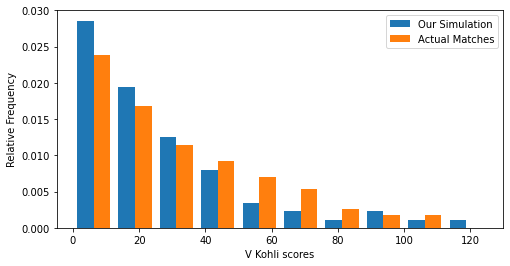

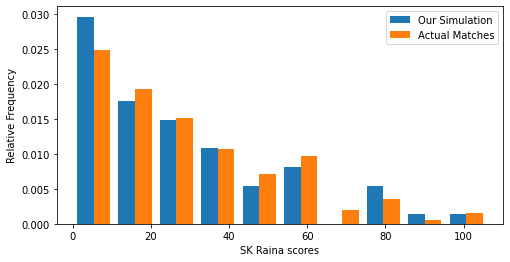

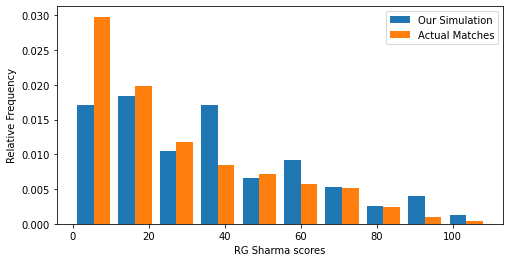

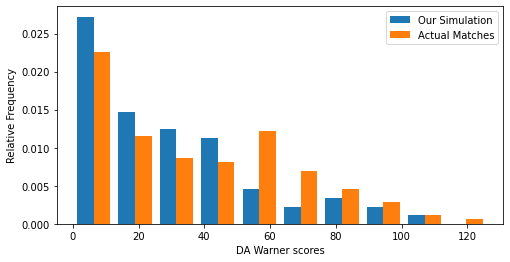

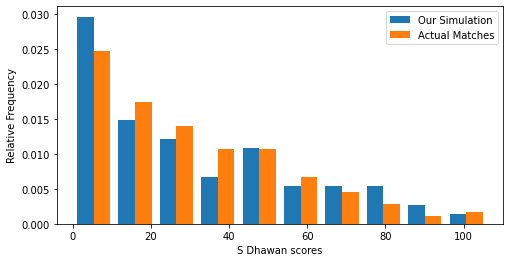

In [22]:
for player in list(actual_batsmen_df["Unnamed: 0"])[:5]: 
    if player not in evaluator.batsmen_stat:
        continue
    player_actual = [i["Runs"] for i in actualstat.batsmen_stat[player]]
    player_evaluator = [i["Runs"] for i in evaluator.batsmen_stat[player]]
    plt.hist([player_evaluator, player_actual], 
            density=True, bins=10,
            label=["Our Simulation", "Actual Matches"])
    plt.legend()
    plt.xlabel(f"{player} scores")
    plt.ylabel("Relative Frequency")
    fig = plt.gcf()
    fig.set_size_inches(8, 4)
    plt.show()

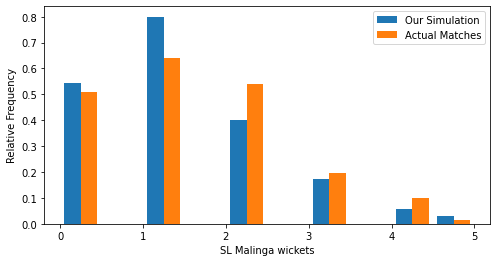

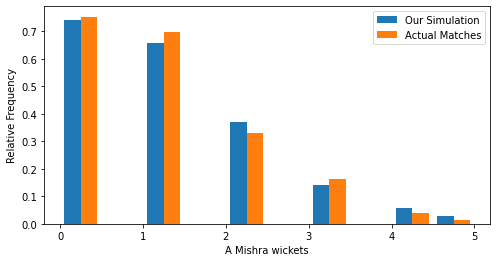

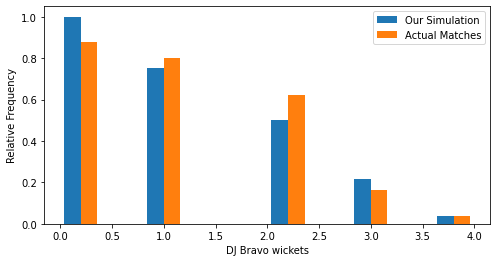

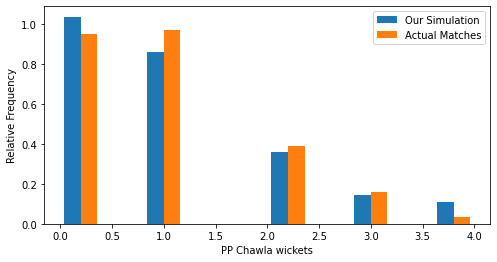

In [23]:
for player in list(actual_bowler_df["Unnamed: 0"])[:5]: 
    if player not in evaluator.bowler_stat:
        continue
    player_actual = [i["Wickets Taken"] for i in actualstat.bowler_stat[player]]
    player_evaluator = [i["Wickets Taken"] for i in evaluator.bowler_stat[player]]
    plt.hist([player_evaluator, player_actual], 
            density=True, bins=10,
            label=["Our Simulation", "Actual Matches"])
    plt.legend()
    plt.xlabel(f"{player} wickets")
    plt.ylabel("Relative Frequency")
    fig = plt.gcf()
    fig.set_size_inches(8, 4)
    plt.show()